# Loading Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%pip install statsmodels
%pip install prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import MinMaxScaler

import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Preprocessing Pizza_Sales Dataset

In [2]:
#Reading the datasets
sales_df=pd.read_excel(r"D:\Vinoth\capstone\Dom2\2\Pizza_Sale.xlsx")
ingredients_df=pd.read_excel(r"D:\Vinoth\capstone\Dom2\2\Pizza_ingredients.xlsx")

In [3]:
sales_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
#Duplicates and NaN counts for Sales data
print(sales_df.duplicated().sum())
print(sales_df.isna().sum())

0
pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64


In [5]:
#Details of the Sales Dataset
print(f'Shape of Sales Dataset:{sales_df.shape}\n')
print(sales_df.info(),'\n')
print(sales_df.describe(),'\n')

Shape of Sales Dataset:(48620, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB
None 

           pizza_id      order_id      quantity    unit_price   total_price
count  48620.000000  48620.000000  486

In [6]:
#handling Missing values for Sales dataset

sales_df['total_price']=sales_df['total_price'].fillna(sales_df['unit_price']*sales_df['quantity'])

pizza_category_mapping = sales_df[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
pizza_category_mapping = pizza_category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()
sales_df['pizza_category'] = sales_df['pizza_category'].fillna(sales_df['pizza_name_id'].map(pizza_category_mapping))

pizza_ingredients_mapping = sales_df[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
pizza_ingredients_mapping = pizza_ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()
sales_df['pizza_ingredients'] = sales_df['pizza_ingredients'].fillna(sales_df['pizza_name'].map(pizza_ingredients_mapping))

pizza_name_mapping = sales_df[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
pizza_name_mapping = pizza_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()
sales_df['pizza_name'] = sales_df['pizza_name'].fillna(sales_df['pizza_ingredients'].map(pizza_name_mapping))

pizza_name_id_mapping = sales_df[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
pizza_name_id_mapping = pizza_name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()
sales_df['pizza_name_id'] = sales_df['pizza_name_id'].fillna(sales_df['pizza_name'].map(pizza_name_id_mapping))

sales_df.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [7]:
sales_df.drop(columns = ['pizza_id'], inplace = True)

# Preprocessing Pizza_Ingredients_Dataset

In [8]:
#Details of Ingredients Dataset
print(f'Shape of Ingredients Dataset:{ingredients_df.shape}\n')
print(ingredients_df.info(),'\n')
print(ingredients_df.describe(),'\n')
ingredients_df.head()

Shape of Ingredients Dataset:(518, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB
None 

       Items_Qty_In_Grams
count          514.000000
mean            30.564202
std             30.351623
min              5.000000
25%             10.000000
50%             20.000000
75%             40.000000
max            200.000000 



,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [9]:
#Duplicates and NaN counts for Ingredients Data
print(ingredients_df.duplicated().sum())
print(ingredients_df.isna().sum())

0
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64


In [10]:
#Handling NaN values from Ingredients Dataset
mean_qty = ingredients_df.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()
ingredients_df['Items_Qty_In_Grams'] = ingredients_df['Items_Qty_In_Grams'].fillna(ingredients_df['pizza_name_id'].map(mean_qty))
ingredients_df.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

# Merging Both the Datasets

In [11]:
#Merging the two datasets
merged_df = pd.merge(sales_df,ingredients_df, on='pizza_name_id', how='inner')
print(f'Shaped of Merged dataset:\n{merged_df.shape}')
print(merged_df.info())
print(merged_df.describe())
print(merged_df.duplicated().sum())
print(merged_df.isna().sum())
merged_df.head()

Shaped of Merged dataset:
(267576, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267576 entries, 0 to 267575
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             267576 non-null  int64  
 1   pizza_name_id        267576 non-null  object 
 2   quantity             267576 non-null  int64  
 3   order_date           267576 non-null  object 
 4   order_time           267576 non-null  object 
 5   unit_price           267576 non-null  float64
 6   total_price          267576 non-null  float64
 7   pizza_size           267576 non-null  object 
 8   pizza_category       267576 non-null  object 
 9   pizza_ingredients_x  267576 non-null  object 
 10  pizza_name_x         267576 non-null  object 
 11  pizza_name_y         267576 non-null  object 
 12  pizza_ingredients_y  267576 non-null  object 
 13  Items_Qty_In_Grams   267576 non-null  float64
dtypes: float64(3), int64(2), obje

,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [12]:
merged_df.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_df.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [13]:
merged_df.duplicated().sum()

np.int64(80204)

In [14]:
# Droping duplicate rows from the dataset
merged_df = merged_df.drop_duplicates()
print(f"Number of rows after removing duplicates: {merged_df.shape[0]}")

Number of rows after removing duplicates: 187372


In [15]:
merged_data = merged_df.copy()

In [16]:
print(merged_df.info(), '\n')
print(merged_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   order_id            187372 non-null  int64  
 1   pizza_name_id       187372 non-null  object 
 2   quantity            187372 non-null  int64  
 3   order_date          187372 non-null  object 
 4   order_time          187372 non-null  object 
 5   unit_price          187372 non-null  float64
 6   total_price         187372 non-null  float64
 7   pizza_size          187372 non-null  object 
 8   pizza_category      187372 non-null  object 
 9   pizza_ingredients   187372 non-null  object 
 10  pizza_name          187372 non-null  object 
 11  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 18.6+ MB
None 

            order_id       quantity     unit_price    total_price  \
count  187372.000000  187372.000000  187372.000000  187

In [17]:
merged_df.drop(columns = ['order_id'], inplace = True)

In [18]:
merged_df.head()

,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams
0,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0
1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0
2,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0
3,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0
6,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0


In [19]:
sales_df.to_csv(r"D:\Vinoth\capstone\Dom2\2\Cleaned_sales_ds.csv", index = False)
ingredients_df.to_csv(r"D:\Vinoth\capstone\Dom2\2\Cleaned_ingredients_ds.csv", index = False)

In [20]:
! pip install holidays


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Feature Extraction

In [21]:
#Handling the dates and applying the holidays and weekend offers

import holidays
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

merged_df['order_date'] = merged_df['order_date'].apply(extract_date)

merged_df['day_of_week'] = merged_df['order_date'].dt.dayofweek # day_name()
merged_df['month'] = merged_df['order_date'].dt.month # month_name()
merged_df['week'] = merged_df['order_date'].dt.isocalendar().week
merged_df['year'] = merged_df['order_date'].dt.year

holiday_list=holidays.US()
merged_df['holiday'] = merged_df['order_date'].apply(lambda x: 1 if x in holiday_list else 0)
merged_df['offer'] = merged_df['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

In [22]:
print(merged_df.shape)
print(merged_df.info())
print(merged_df.describe())
merged_df.isna().sum()

(187372, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_name_id       187372 non-null  object        
 1   quantity            187372 non-null  int64         
 2   order_date          187372 non-null  datetime64[ns]
 3   order_time          187372 non-null  object        
 4   unit_price          187372 non-null  float64       
 5   total_price         187372 non-null  float64       
 6   pizza_size          187372 non-null  object        
 7   pizza_category      187372 non-null  object        
 8   pizza_ingredients   187372 non-null  object        
 9   pizza_name          187372 non-null  object        
 10  Items_Qty_In_Grams  187372 non-null  float64       
 11  day_of_week         187372 non-null  int32         
 12  month               187372 non-null  int32         
 13  week                1

pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
day_of_week           0
month                 0
week                  0
year                  0
holiday               0
offer                 0
dtype: int64

In [23]:
merged_df.to_csv(r"D:\Vinoth\capstone\Dom2\2\Final_dataset.csv", index = False)

In [24]:
#Sales by order date
daily_sales=merged_df.groupby('order_date')['quantity'].sum().reset_index()
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


In [25]:
# A week pizza sales
week_7_sales = merged_df[merged_df['week'] == 7]
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 299 pizzas
The Big Meat Pizza: 96 pizzas
The Brie Carre Pizza: 32 pizzas
The Calabrese Pizza: 88 pizzas
The California Chicken Pizza: 226 pizzas
The Chicken Alfredo Pizza: 133 pizzas
The Chicken Pesto Pizza: 64 pizzas
The Classic Deluxe Pizza: 132 pizzas
The Five Cheese Pizza: 58 pizzas
The Four Cheese Pizza: 181 pizzas
The Greek Pizza: 141 pizzas
The Green Garden Pizza: 78 pizzas
The Hawaiian Pizza: 105 pizzas
The Italian Capocollo Pizza: 132 pizzas
The Italian Supreme Pizza: 148 pizzas
The Italian Vegetables Pizza: 59 pizzas
The Mediterranean Pizza: 73 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 68 pizzas
The Pepper Salami Pizza: 80 pizzas
The Pepperoni Pizza: 98 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 33 pizzas
The Prosciutto and Arugula Pizza: 71 pizzas
The Sicilian Pizza: 176 pizzas
The Soppressata Pizza: 68 pizzas
The Southwest Chicken Pizza: 170 pizzas
The Spicy Italian Pizza: 161 pizzas
The Spinach Pe

# Exploratory Data Analysis and Data Visualization

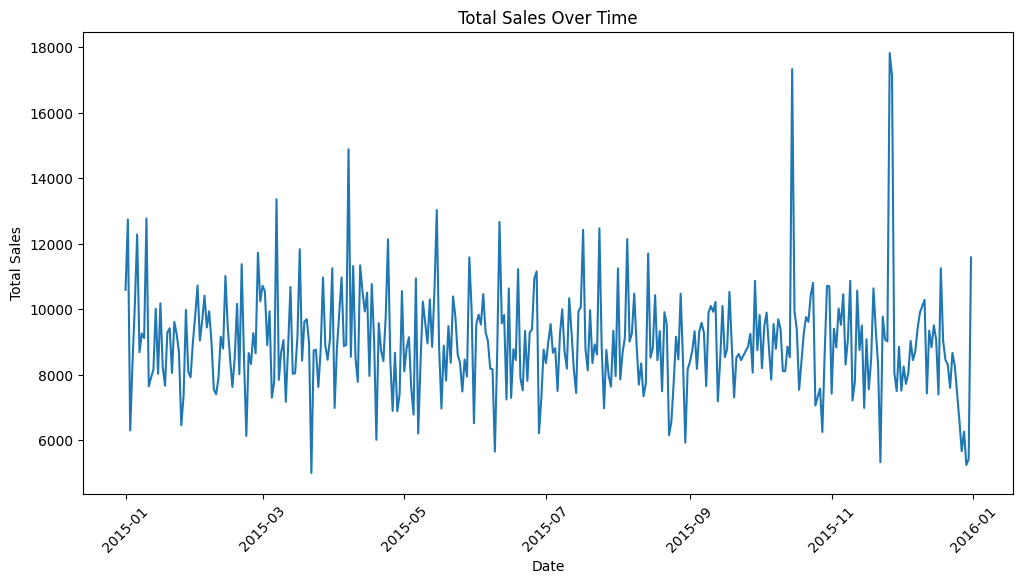

In [26]:
# Data Visualization
# Sales over time
sales_over_time = merged_df.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

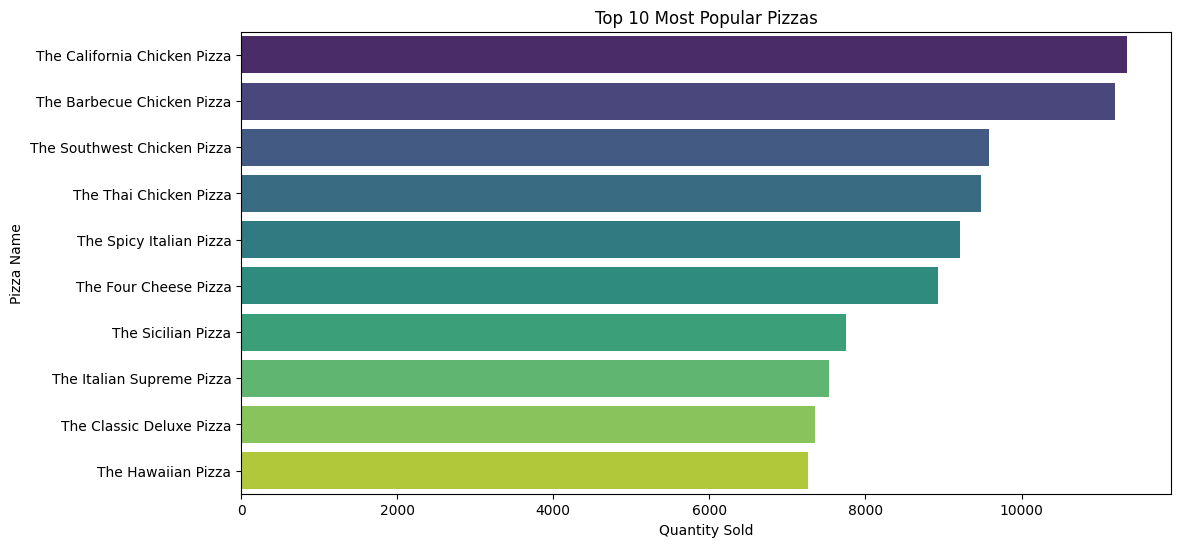

In [27]:
#Top Selling Pizzas
pizza_sales = merged_df.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

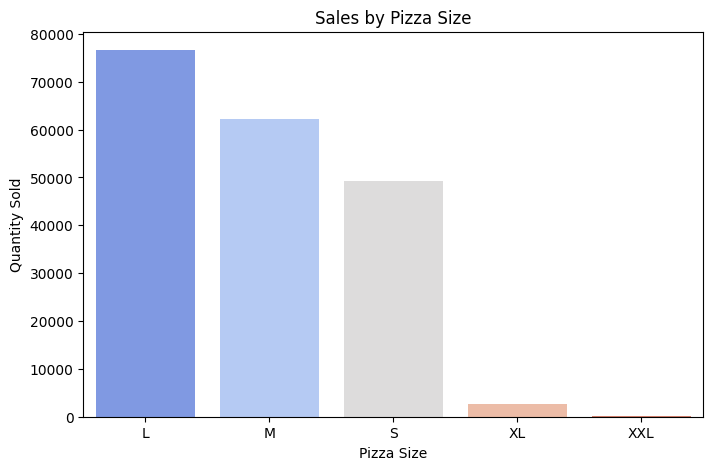

In [28]:
#Sales by Pizza Size
size_sales = merged_df.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

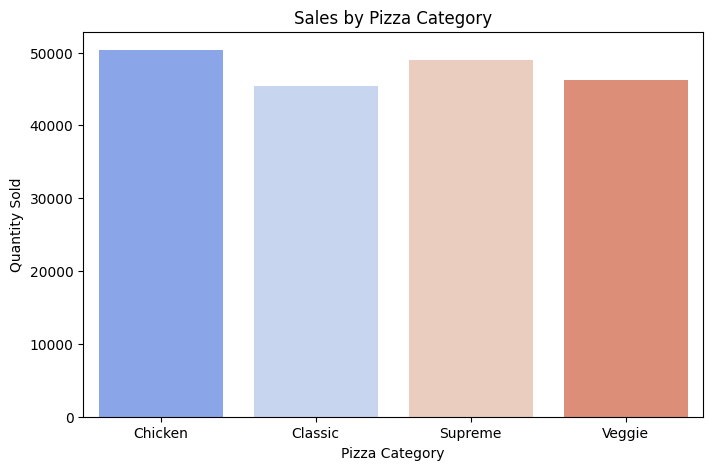

In [29]:
#Sales by Pizza Category
category_sales = merged_df.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

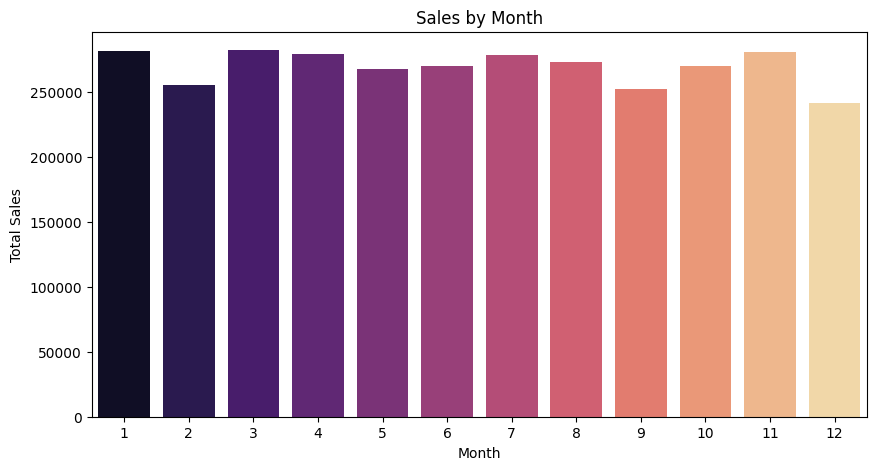

In [30]:
#sales by Month
sales_by_month = merged_df.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

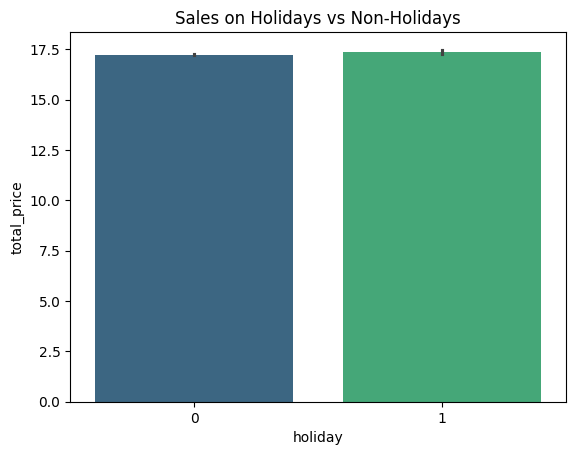

In [31]:
#Sales during holidays
sns.barplot(x='holiday', y='total_price', data=merged_df, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

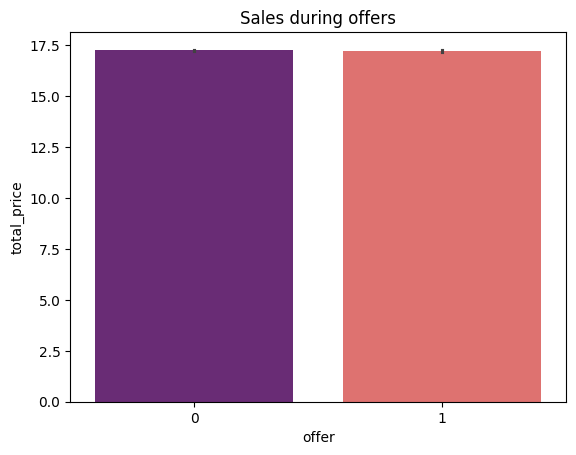

In [32]:
#Sales during Offers
sns.barplot(x='offer', y='total_price', data=merged_df, palette='magma')
plt.title('Sales during offers')
plt.show()

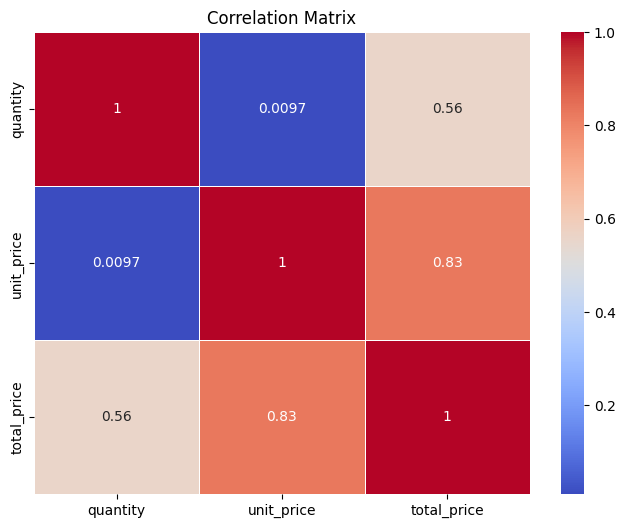

In [33]:
# Correlation matrix
corr_matrix = merged_df[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

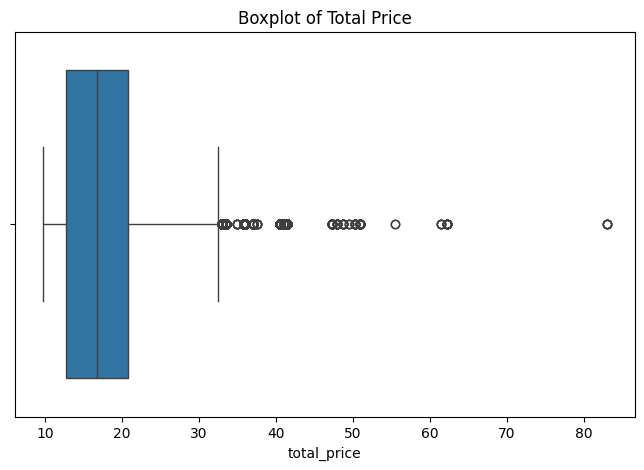

In [34]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

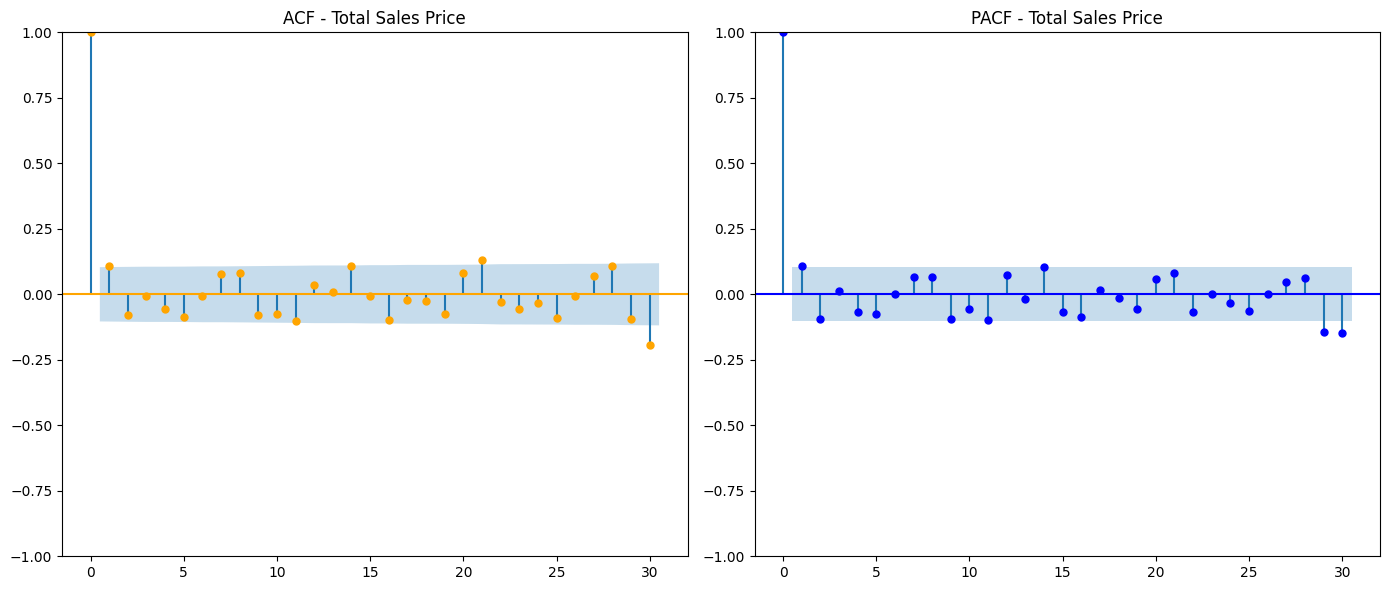

In [35]:
daily_sales = merged_df.groupby('order_date').agg({'total_price': 'sum', 'quantity': 'sum'}).reset_index()


# Plotting ACF and PACF for time series sales data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(daily_sales['total_price'], lags=30, ax=plt.gca(), color='orange')
plt.title('ACF - Total Sales Price')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(daily_sales['total_price'], lags=30, ax=plt.gca(), color='blue')
plt.title('PACF - Total Sales Price')

plt.tight_layout()
plt.show()

In [36]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on total sales
result = adfuller(daily_sales['total_price'])
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Statistic: {adf_statistic}, p-value: {p_value}')

# Check for stationarity based on p-value
if p_value <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -9.993019851518202, p-value: 1.9731943283207953e-17
The time series is stationary.


# Models Training

Best ARIMA Model MAPE: 0.1974, Best Parameters: (3, 1, 5)
Predictions:
order_date
2015-10-19    3439.686655
2015-10-26    3841.247035
2015-11-02    3632.486847
2015-11-09    3651.994504
2015-11-16    3555.859663
2015-11-23    3875.473489
2015-11-30    3531.309476
2015-12-07    3663.572793
2015-12-14    3651.586673
2015-12-21    3820.650117
2015-12-28    3460.570637
Name: predicted_mean, dtype: float64


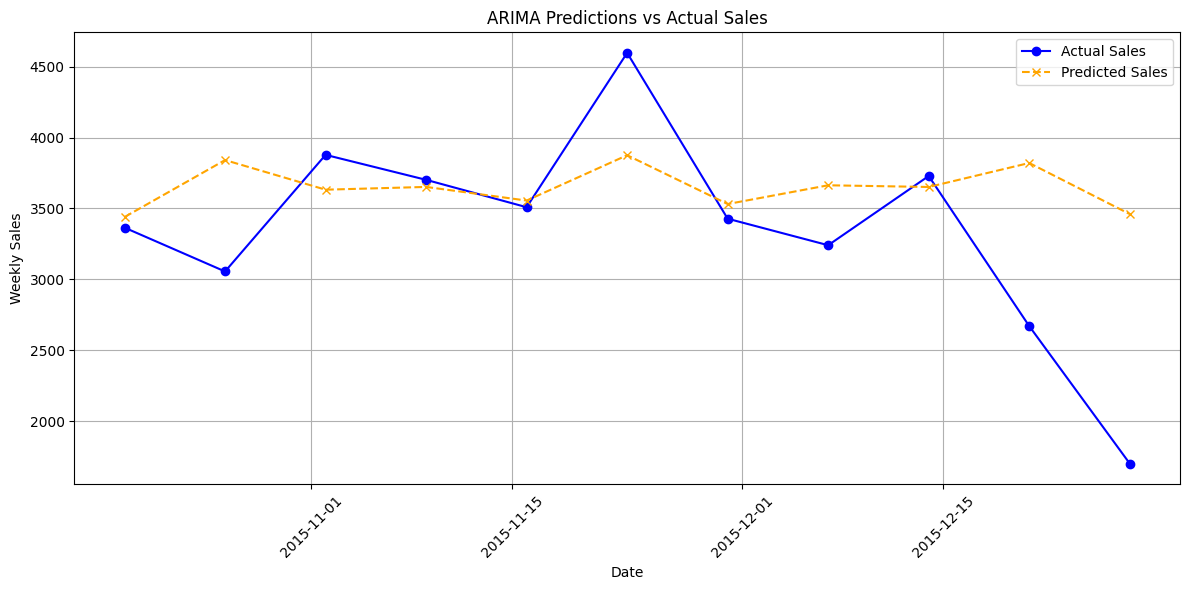

In [37]:
#ARIMA Model
import itertools

# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_df)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Best SARIMA Model MAPE: 0.2327
Predictions:
order_date
2015-10-19    3639.064910
2015-10-26    3962.060823
2015-11-02    3803.567957
2015-11-09    3536.255627
2015-11-16    3700.833930
2015-11-23    3810.493794
2015-11-30    3827.372019
2015-12-07    3746.217257
2015-12-14    4015.172847
2015-12-21    3866.686564
2015-12-28    3566.403151
Name: predicted_mean, dtype: float64


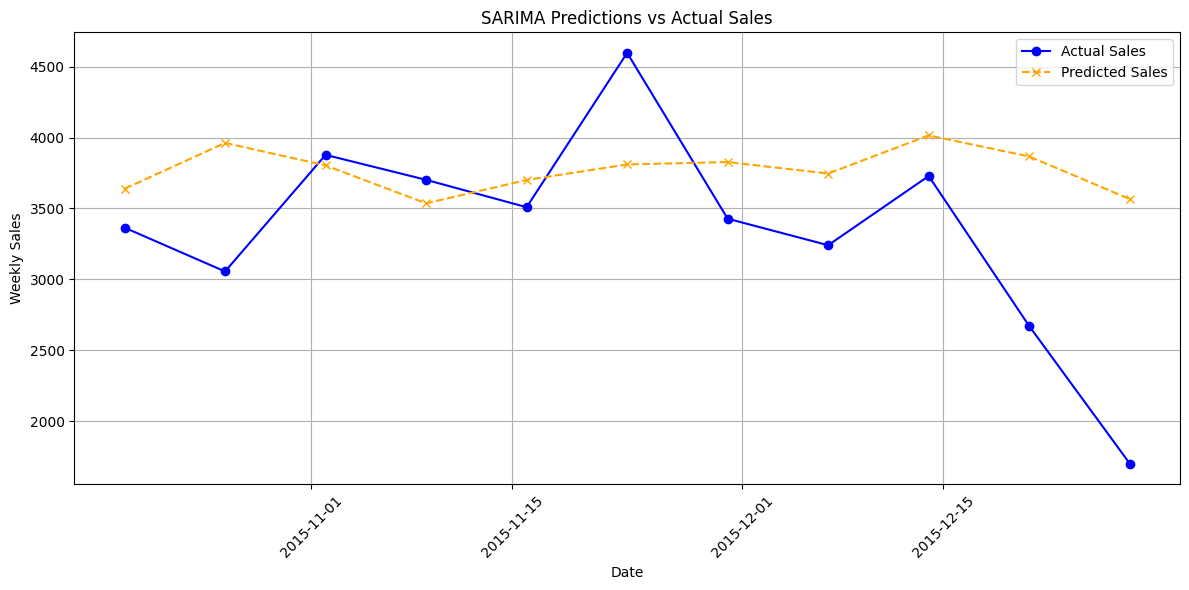

In [38]:
#SARIMA Model
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_df)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:55 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.2163
Predictions:
ds
2015-10-19    3684.955697
2015-10-26    3685.691317
2015-11-02    3686.426937
2015-11-09    3687.162557
2015-11-16    3687.898177
2015-11-23    3688.633796
2015-11-30    3689.369416
2015-12-07    3690.105036
2015-12-14    3690.840656
2015-12-21    3691.576276
2015-12-28    3692.311896
dtype: float64


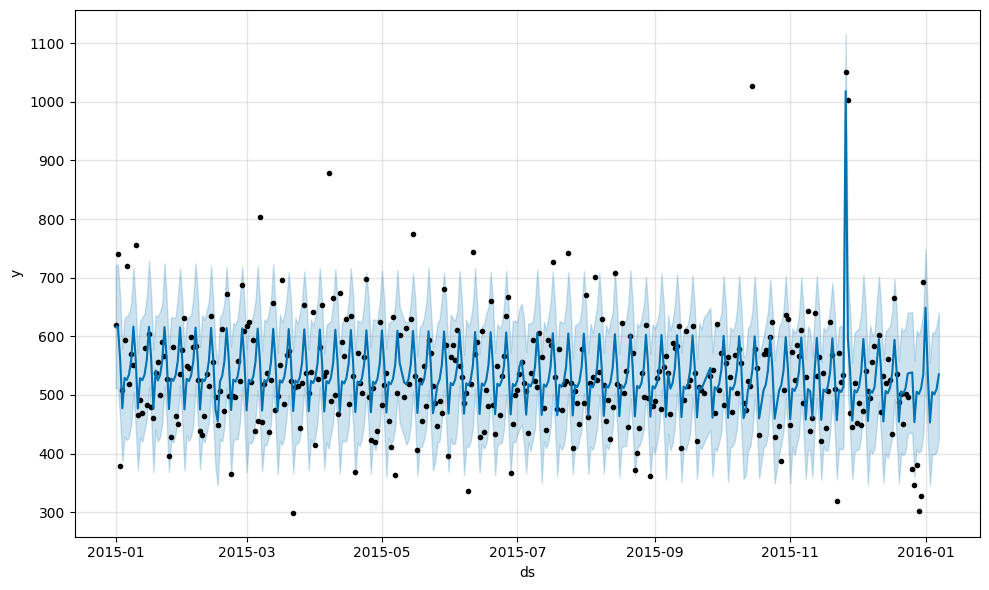

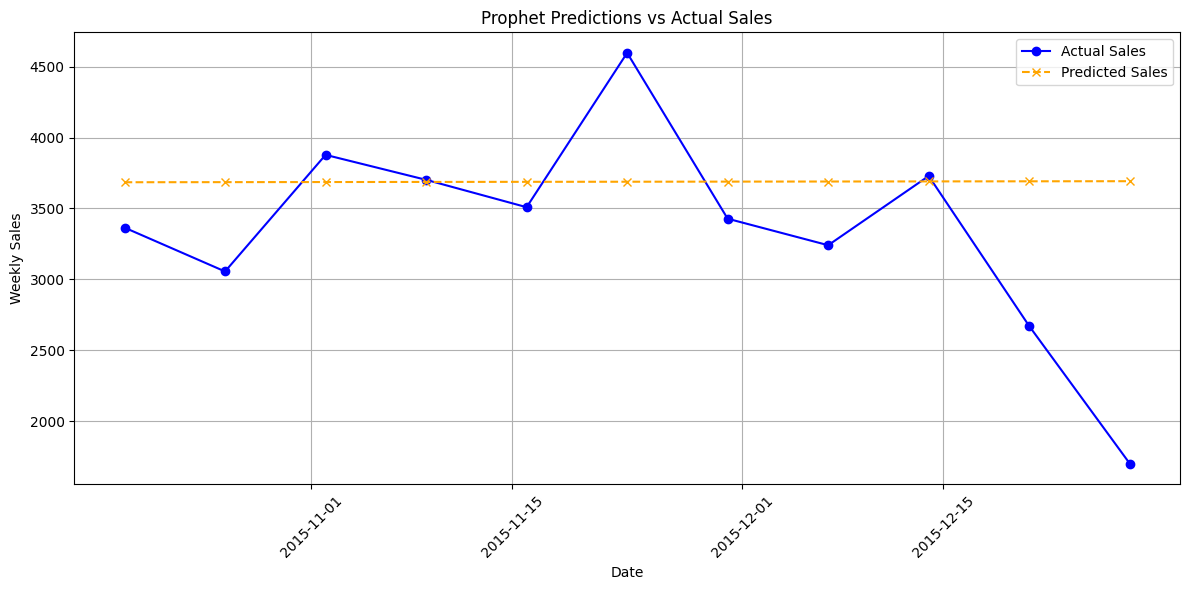

In [39]:
# Prophet model
daily_sales['order_date'] = pd.to_datetime(daily_sales['order_date'])

# renameing the columns to 'ds' for dates and 'y' for the target values
prophet_data = daily_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'})

# Model fiting
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(prophet_data)

# Future forecast for the next 7 days
future_dates = prophet_model.make_future_dataframe(periods=7)
prophet_forecast = prophet_model.predict(future_dates)

# Displaying the forecast
fig = prophet_model.plot(prophet_forecast)

def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(merged_df)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)

    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)

    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Best Regression Model MAPE: 0.1906
Predictions:
order_date
2015-10-19    3593.582950
2015-10-26    3540.495581
2015-11-02    3700.838915
2015-11-09    3647.751546
2015-11-16    3594.664177
2015-11-23    3541.576808
2015-11-30    3488.489439
2015-12-07    3648.832773
2015-12-14    3595.745404
2015-12-21    3542.658035
2015-12-28    3489.570666
dtype: float64


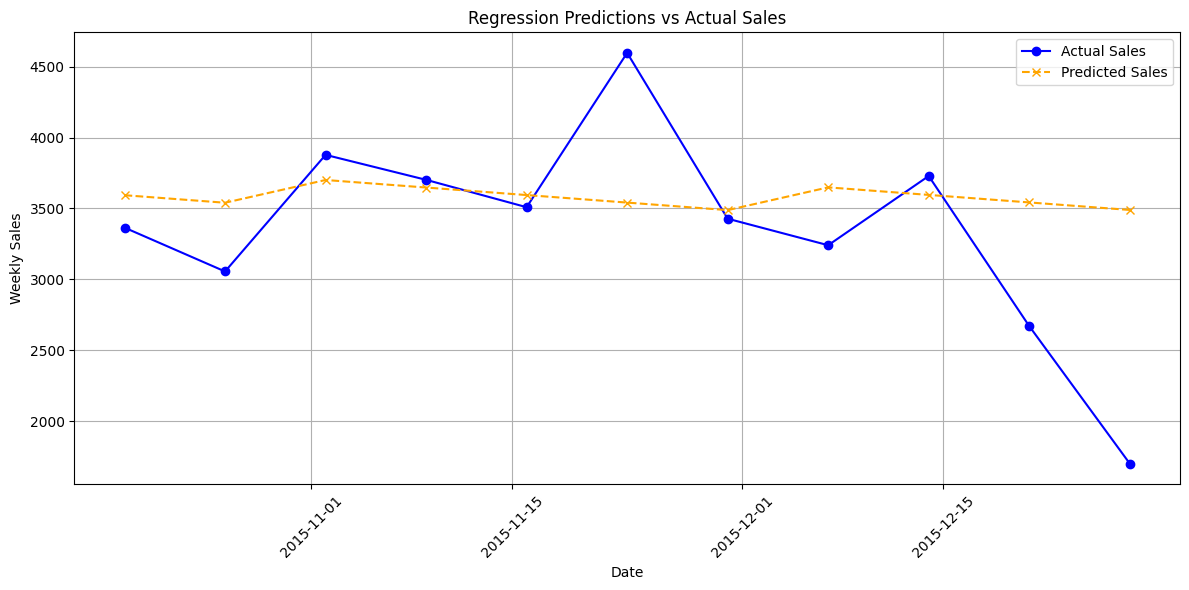

In [40]:
# Regression Model
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

# Feature Engineering for Regression
def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(merged_df)
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepareing data for Regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)

    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return model,predictions, regression_mape

# Train and evaluate the Regression model
best_model, regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [41]:
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow


# Model Evaluation

In [42]:
#Model evaluation
import pandas as pd

# Model results as a dictionary
model_performance = {
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Regression'],
    'MAPE': [0.1895, 0.1849, 0.1962, 0.1911],
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
1,SARIMA,0.1849,1.0,Best
0,ARIMA,0.1895,2.0,
3,Regression,0.1911,3.0,
2,Prophet,0.1962,4.0,Worst


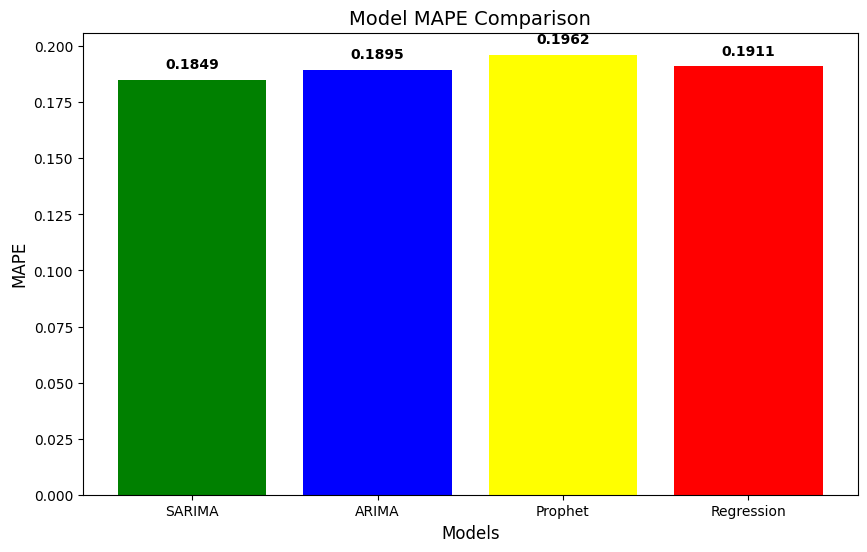

In [43]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Prophet', 'Regression']
mapes = [0.1849, 0.1895, 0.1962, 0.1911]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'yellow', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()

In [44]:
# SARIMA Model forecasted sales for the week:

# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(merged_df)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]
        
        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 69 pizzas
bbq_ckn_m: 111 pizzas
bbq_ckn_s: 31 pizzas
big_meat_s: 102 pizzas
brie_carre_s: 46 pizzas
calabrese_l: 14 pizzas
calabrese_m: 35 pizzas
cali_ckn_l: 96 pizzas
cali_ckn_m: 80 pizzas
cali_ckn_s: 35 pizzas
ckn_alfredo_l: 19 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 34 pizzas
ckn_pesto_m: 17 pizzas
ckn_pesto_s: 15 pizzas
classic_dlx_l: 28 pizzas
classic_dlx_m: 66 pizzas
classic_dlx_s: 43 pizzas
five_cheese_l: 47 pizzas
four_cheese_l: 166 pizzas
four_cheese_m: 46 pizzas
green_garden_l: 6 pizzas
green_garden_m: 36 pizzas
green_garden_s: 40 pizzas
hawaiian_l: 47 pizzas
hawaiian_m: 17 pizzas
hawaiian_s: 49 pizzas
ital_cpcllo_l: 58 pizzas
ital_cpcllo_m: 44 pizzas
ital_cpcllo_s: 33 pizzas
ital_supr_l: 58 pizzas
ital_supr_m: 71 pizzas
ital_supr_s: 11 pizzas
ital_veggie_m: 41 pizzas
ital_veggie_s: 13 pizzas
mediterraneo_l: 37 pizzas
mediterraneo_m: 36 pizzas
mediterraneo_s: 24 pizzas
mexicana_l:

# Hyperparameter Tuning for SARIMA

                                     SARIMAX Results                                     
Dep. Variable:                          quantity   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -258.238
Date:                           Wed, 04 Jun 2025   AIC                            526.477
Time:                                   18:12:48   BIC                            534.109
Sample:                                        0   HQIC                           529.080
                                            - 42                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1374      0.318     -0.432      0.666      -0.761       0.486
ma.L1         -0.6730      0.275     -2.446

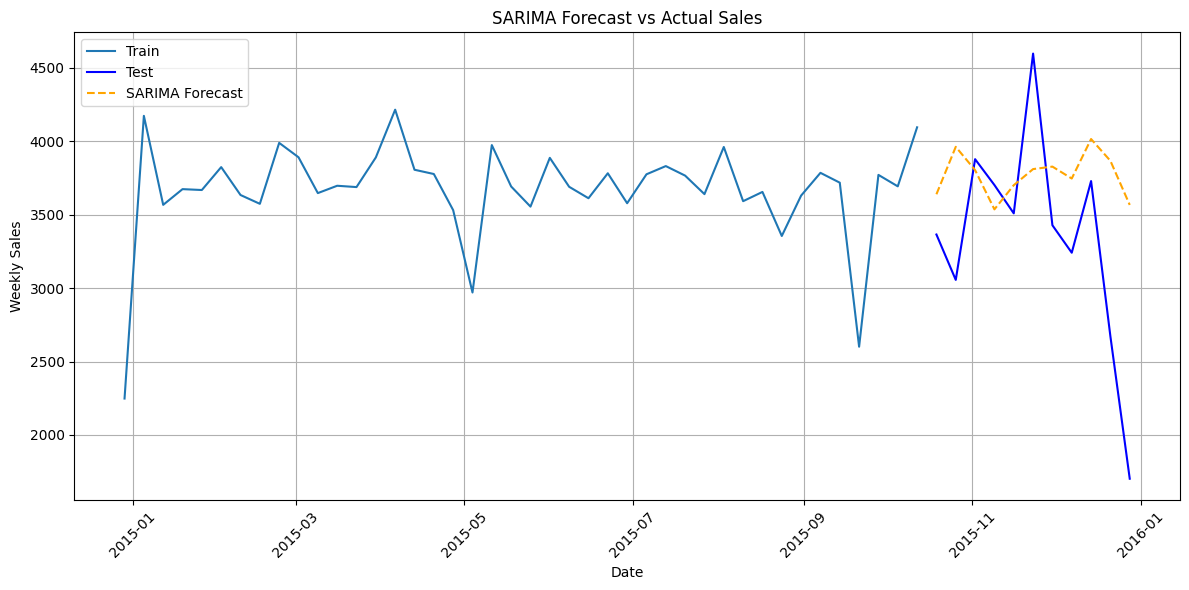

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use only the 'quantity' column for modeling
train_series = train['quantity']
test_series = test['quantity']

# Fit SARIMA model manually
sarima_model = SARIMAX(train_series, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 7)).fit(disp=False)

print(sarima_model.summary())

# Forecasting
n_test = len(test_series)
sarima_forecast = sarima_model.forecast(steps=n_test)

# Evaluate performance (optional)
from sklearn.metrics import mean_absolute_percentage_error as mape
sarima_mape = mape(test_series, sarima_forecast)
print(f"SARIMA MAPE: {sarima_mape:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train['order_date'], train['quantity'], label='Train')
plt.plot(test['order_date'], test['quantity'], label='Test', color='blue')
plt.plot(test['order_date'], sarima_forecast, label='SARIMA Forecast', color='orange', linestyle='--')
plt.title('SARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [57]:
import pickle # Importing pickle for saving the model
# Save the model to a file using pickle
model_filename = r"D:\Vinoth\capstone\Dom2\2\Best_Sarima_Model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(sarima_model, file)
print(f"Model saved as {model_filename}")

Model saved as D:\Vinoth\capstone\Dom2\2\Best_Sarima_Model.pkl


In [58]:
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")

Model loaded successfully.


In [71]:
import pickle
import pandas as pd

# Load the trained model
model_filename = 'Best_Sarima_Model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Load cleaned sales data (ensure 'order_date' is parsed as datetime)
train = pd.read_csv('Cleaned_sales_ds.csv', parse_dates=['order_date'])
train.set_index('order_date', inplace=True)

# Get the last date and ensure it is datetime
last_date = pd.to_datetime(train.index[-1])

# Forecast the next 7 periods
forecast_result = loaded_model.get_forecast(steps=7)

# Generate weekly forecast index starting from the next Sunday
forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=7, freq='W')

# Create forecast series
forecast_series = pd.Series(forecast_result.predicted_mean.values, index=forecast_index)
forecast_series.name = "predicted_sales"

# Print the forecast
print(forecast_series)

2016-01-10    3639.064910
2016-01-17    3962.060823
2016-01-24    3803.567957
2016-01-31    3536.255627
2016-02-07    3700.833930
2016-02-14    3810.493794
2016-02-21    3827.372019
Freq: W-SUN, Name: predicted_sales, dtype: float64


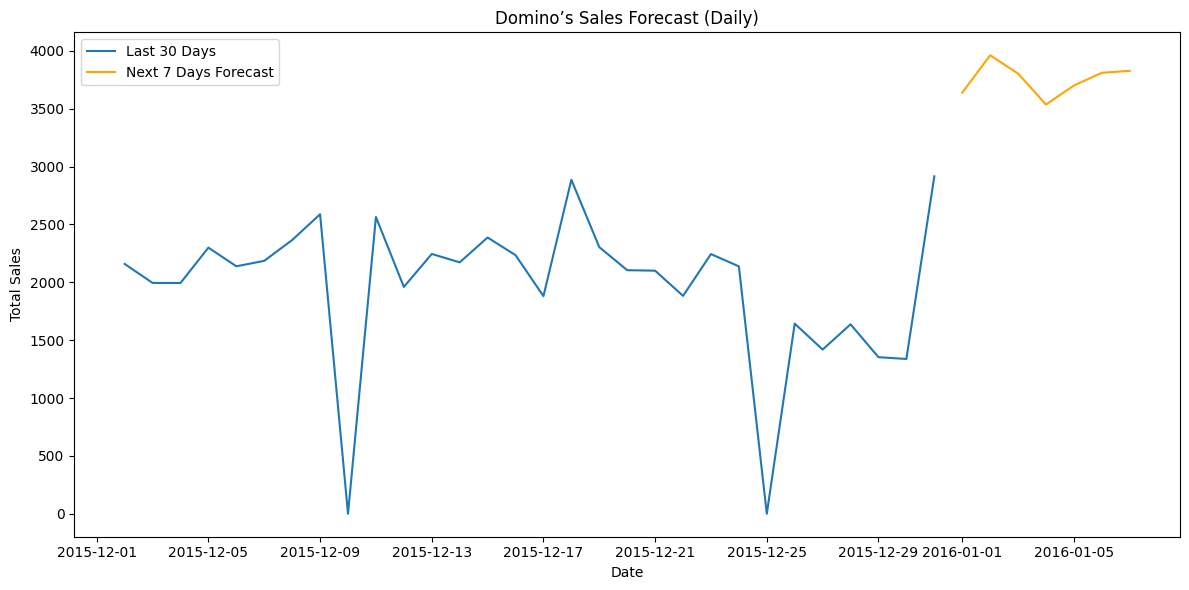

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Load SARIMA model
with open('Best_Sarima_Model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Load and process data
df = pd.read_csv('Cleaned_sales_ds.csv')

# ✅ Robust date conversion
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True, format='mixed')

# Daily sales aggregation
df = df.groupby('order_date').agg({'total_price': 'sum'})
df = df.asfreq('D').fillna(0)

# Forecast next 7 days
n_forecast = 7
forecast = best_model.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast, freq='D')
forecast_series = pd.Series(forecast_values.values, index=forecast_index)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-30:], df['total_price'][-30:], label='Last 30 Days')
plt.plot(forecast_series.index, forecast_series, label='Next 7 Days Forecast', color='orange')
plt.title('Domino’s Sales Forecast (Daily)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import numpy as np

# Load ingredients dataset
Ingredients_dataset = pd.read_csv(r"D:\Vinoth\capstone\Dom2\2\Cleaned_ingredients_ds.csv")

# Forecasted total sales for the next week (use first 7 values if weekly)
weekly_forecast = [2012.53, 3824.72, 3660.10, 3660.80, 3653.61, 3904.61, 4797.65]  # or use forecast[:7].tolist()
total_weekly_sales = sum(weekly_forecast)

# Get all unique pizza IDs
pizza_ids = Ingredients_dataset["pizza_name_id"].unique()

# Distribute sales equally across all pizzas (you can adjust this later with real proportions)
avg_sales_per_pizza = total_weekly_sales / len(pizza_ids)

# Create forecast mapping
next_week_pizza_sales_forecasts_arima = {pizza: avg_sales_per_pizza for pizza in pizza_ids}

# Proceed with mapping and ingredient quantity calculations
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum up by ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()

print("✅ Total quantity of predicted ingredients for the upcoming week:")
for ingredient, qty in ingredient_totals.items():
    print(f"{ingredient}: {round(qty, 2)} grams")

✅ Total quantity of predicted ingredients for the upcoming week:
?duja Salami: 33644.86 grams
Alfredo Sauce: 12616.82 grams
Anchovies: 23831.78 grams
Artichokes: 75700.94 grams
Arugula: 8411.22 grams
Asiago Cheese: 50467.29 grams
Bacon: 117757.02 grams
Barbecue Sauce: 8411.22 grams
Barbecued Chicken: 25233.65 grams
Beef Chuck Roast: 159813.09 grams
Blue Cheese: 8411.22 grams
Brie Carre Cheese: 8411.22 grams
Calabrese Salami: 84112.15 grams
Capocollo: 336448.62 grams
Caramelized Onions: 4485.98 grams
Chicken: 420560.77 grams
Chipotle Sauce: 33644.86 grams
Chorizo Sausage: 14018.69 grams
Cilantro: 16822.43 grams
Coarse Sicilian Salami: 67289.72 grams
Corn: 112149.54 grams
Eggplant: 33644.86 grams
Feta Cheese: 117757.02 grams
Fontina Cheese: 33644.86 grams
Friggitello Peppers: 8411.22 grams
Garlic: 168224.31 grams
Genoa Salami: 50467.29 grams
Goat Cheese: 67289.72 grams
Gorgonzola Piccante Cheese: 16822.43 grams
Gouda Cheese: 16822.43 grams
Green Olives: 33644.86 grams
Green Peppers: 4626

In [7]:
ingredient_totals

{'?duja Salami': 33644.86153846154,
 'Alfredo Sauce': 12616.823076923078,
 'Anchovies': 23831.776923076926,
 'Artichokes': 75700.93846153846,
 'Arugula': 8411.215384615385,
 'Asiago Cheese': 50467.29230769231,
 'Bacon': 117757.01538461538,
 'Barbecue Sauce': 8411.215384615385,
 'Barbecued Chicken': 25233.646153846155,
 'Beef Chuck Roast': 159813.0923076923,
 'Blue Cheese': 8411.215384615385,
 'Brie Carre Cheese': 8411.215384615385,
 'Calabrese Salami': 84112.15384615384,
 'Capocollo': 336448.6153846154,
 'Caramelized Onions': 4485.981538461539,
 'Chicken': 420560.76923076925,
 'Chipotle Sauce': 33644.86153846154,
 'Chorizo Sausage': 14018.692307692309,
 'Cilantro': 16822.43076923077,
 'Coarse Sicilian Salami': 67289.72307692308,
 'Corn': 112149.53846153847,
 'Eggplant': 33644.86153846154,
 'Feta Cheese': 117757.0153846154,
 'Fontina Cheese': 33644.86153846154,
 'Friggitello Peppers': 8411.215384615385,
 'Garlic': 168224.3076923077,
 'Genoa Salami': 50467.29230769231,
 'Goat Cheese': 67

In [8]:
# Saveing the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


<Figure size 2500x1500 with 0 Axes>

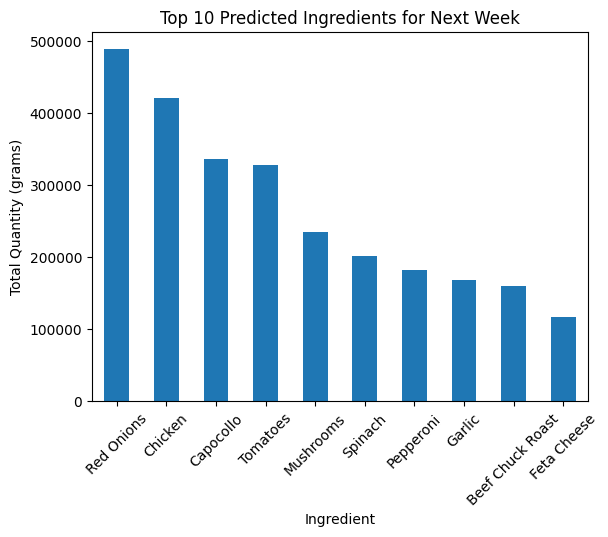

In [9]:
# Visualizing the total quantities of ingredients
plt.figure(figsize=(25, 15))
ingredient_totals_df.nlargest(10, 'Total Quantity (grams)').plot(kind='bar', x='Ingredient', y='Total Quantity (grams)', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.show()

In [10]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,33644.861538
1,Alfredo Sauce,12616.823077
2,Anchovies,23831.776923
3,Artichokes,75700.938462
4,Arugula,8411.215385
...,...,...
59,Sun-dried Tomatoes,16822.430769
60,Thai Sweet Chilli Sauce,16822.430769
61,Thyme,1401.869231
62,Tomatoes,328037.400000


In [11]:
predicted_ingredient_totals.to_csv(r"D:\Vinoth\capstone\Dom2\2\Ingredients_details.csv", index = False)